In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
import statsmodels.api as sm
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import warnings
from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

#          Introduction


All of us are huge basketball fans and have heard our whole lives that an increase in height will lead to a more successful basketball career. However, we noticed a new trend in the NBA where teams decided to have line-ups with shorter players as opposed to taller players in the NBA. We also saw a lot of initial success in NBA line-ups where the tallest player was under 6 foot 8 inches such as the 2015-2019 Golden State Warriors. The Golden State Warriors had won 3 NBA championships in that span. Furthermore, the 2019 Houston Rockets did not even have a player taller than 6 foot 8 inches on their whole roster and went to the second round of the NBA playoffs. Our initial hypothesis was that we thought that lower height and weight statistics led to higher win rates in the NBA. As a result, we found datasets that give the winning percentage of every NBA team ever and the height and weight of every NBA player ever to play  to help determine the validity of our hypothesis. 





In [ ]:
#Cleaning up data for our analysis

#Historical Winning Percentages for all NBA team
team_records = pd.read_csv("Historical NBA Performance.csv", usecols=[0,1,2,3])

#Historical Player Statistics
player_teamid = pd.read_csv("NBA Season Data.csv")
player_teamid['Player'][17262]
player_teamid = player_teamid[:17263]
start_year = []
end_year = []

#Dict for comparing teamID to real team name (as team names change)
nba_dict = {'NOJ' : 'Jazz', 'BUF' : 'Clippers', 'WSB' : 'Bullets', 
            'BOS' : 'Celtics', 'NYK' : 'Knicks', 'NJN' : 'Nets', 
            'CHI' : 'Bulls', 'DEN' : 'Nuggets', 'GSW' : 'Warriors', 
            'IND' : 'Pacers', 'KCK' : 'Kings', 'HOU' : 'Rockets', 
            'SEA' : 'Supersonics', 'CLE' : 'Cavaliers', 'SAS' : 'Spurs',
            'LAL' : 'Lakers', 'PHI' : '76ers', 'MIL' : 'Bucks',
            'POR' : 'Trail Blazers', 'PHO' : 'Suns', 'DET' : 'Pistons',
            'ATL' : 'Hawks', 'SDC' : 'Clippers', 'UTA' : 'Jazz',
            'DAL' : 'Mavericks', 'LAC' : 'Clippers', 'SAC' : 'Kings',
            'MIA' : 'Heat', 'CHH' : 'Hornets', 'MIN' : 'Timberwolves',
            'ORL' : 'Magic', 'TOR' : 'Raptors', 'VAN' : 'Grizzlies',
            'WAS' : 'Wizards', 'MEM' : 'Grizzlies', 'NOH' : 'Hornets',
            'CHA' : 'Bobcats', 'NOK' : 'Hornets', 'OKC' : 'Thunder',
            'BRK' : 'Nets', 'NOP' : 'Pelicans', 'CHO' : 'Hornets'}

#Iterate through the dataframe, and change the startyear,endyear format for the
#season into two different columns for start year and end year
for index, row in team_records.iterrows():
  team_records['Year'][index] = team_records['Year'][index][:7]
  start_year.append(int(team_records['Year'][index][:4]))
  end_year.append(int(team_records['Year'][index][:2] + team_records['Year'][index][-2:]))

#Add start year and end year columns back into dataframe
team_records['start_year'] = start_year
team_records['end_year'] = end_year

#During parsing, the value 1900 is created, for simplicity, I replace it here
team_records = team_records.replace(to_replace='1900', value='2000')

#Remove all columns previous to 1980 so it matches with the other dataframe
team_records = team_records[(team_records.start_year >= 1980)]

#Delete unnecessary Year column
del(team_records['Year'])

#Reformat TrueSalary column to that way it is a float
player_teamid['TrueSalary'] = player_teamid['TrueSalary'].str.replace(',', '')
player_teamid['TrueSalary'] = player_teamid['TrueSalary'].str.replace('$', '')
player_teamid['TrueSalary'] = pd.to_numeric(player_teamid['TrueSalary'])

#Display both dataframes being used
print("Player Data")
display(player_teamid)
print("Team Winning Percentages")
display(team_records)



Player Data


Year   Tm              Player  ...  Weight  Rounded Position  Rounded Age
0      1978  NOJ      Truck Robinson  ...   225.0               4.0         26.0
1      1978  BUF         Randy Smith  ...   180.0               1.0         29.0
2      1978  WSB         Elvin Hayes  ...   235.0               4.0         32.0
3      1978  BOS         Dave Cowens  ...   230.0               4.0         29.0
4      1978  NYK          Bob McAdoo  ...   210.0               4.0         26.0
...     ...  ...                 ...  ...     ...               ...          ...
17258  2016  ATL      Walter Tavares  ...   260.0               5.0         24.0
17259  2016  IND  Shayne Whittington  ...   250.0               4.0         25.0
17260  2016  IND        Solomon Hill  ...   225.0               2.0         25.0
17261  2016  UTA         Jeff Withey  ...   231.0               4.0         26.0
17262  2016  CHI   Cristiano Felicio  ...   275.0               1.0         24.0

[17263 rows x 109 columns]

Team Winning Percentages


Team Record  Winning Percentage  start_year  end_year
0     Celtics  25-15               0.625        2016      2017
1     Celtics  48-34               0.585        2015      2016
2     Celtics  40-42               0.488        2014      2015
3     Celtics  25-57               0.305        2013      2014
4     Celtics  41-40               0.506        2012      2013
...       ...    ...                 ...         ...       ...
1393  Bullets  40-42               0.488        1984      1985
1394  Bullets  35-47               0.427        1983      1984
1395  Bullets  42-40               0.512        1982      1983
1396  Bullets  43-39               0.524        1981      1982
1397  Bullets  39-43               0.476        1980      1981

[1022 rows x 5 columns]

In this section, we are retrieving data from both datasets to test our hypothesis and determine the validity of it. 



In [ ]:
#Copy team_records dataframe into new dataframe to be used for actual processing
df = team_records.copy(deep=True)

#Create new columns for average height, weight, years of experience, and salary.
df['avg_height'] = ([None] * len(df))
df['avg_weight'] = ([None] * len(df))
df['years_exp'] = ([None] * len(df))
df['avg_salary'] = ([None] * len(df))

#Iterate through each team
for key in nba_dict.keys():

  #Create a dataframe with each player on that respective team
  temp_df = pd.DataFrame(data=None, columns=df.columns)
  temp_df = player_teamid[(player_teamid.Tm == key)]

  years = temp_df.Year.unique()

  temp_df2 = pd.DataFrame(data=None, columns=df.columns)
  
  #Iterate through each year for each respective team
  for year in years:
    #Create a second dataframe that contains all the players for the current
    #team, on the current year
    temp_df2 = temp_df[(temp_df.Year == year)]
    
    #Get the index where that team and year is located
    idx = df.index[(df['end_year'] == year) & (df['Team'] == nba_dict[key])]

    #Using the above index, save the average height, weight, years of experience,
    #and salary to the main dataframe
    df['avg_height'][idx] = temp_df2['Height'].mean()
    df['avg_weight'][idx] = temp_df2['Weight'].mean()
    df['years_exp'][idx] = temp_df2['Yrs Experience'].mean()
    df['avg_salary'][idx] = temp_df2['TrueSalary'].mean()

display(df)

Team Record  Winning Percentage  ...  avg_weight  years_exp   avg_salary
0     Celtics  25-15               0.625  ...        None       None         None
1     Celtics  48-34               0.585  ...     222.643    3.64286     2.19e+06
2     Celtics  40-42               0.488  ...     218.636    4.54545  4.06667e+06
3     Celtics  25-57               0.305  ...     216.316    4.05263  2.76667e+06
4     Celtics  41-40               0.506  ...         222          6  4.47143e+06
...       ...    ...                 ...  ...         ...        ...          ...
1393  Bullets  40-42               0.488  ...     207.667    3.53333  6.74545e+06
1394  Bullets  35-47               0.427  ...     211.143        2.5  5.36667e+06
1395  Bullets  42-40               0.512  ...     210.158    3.10526  5.43077e+06
1396  Bullets  43-39               0.524  ...     207.308    3.07692  5.30833e+06
1397  Bullets  39-43               0.476  ...     204.722    4.22222  6.53636e+06

[1022 rows x 9 columns]

In this section, we are taking the data from the dataset and storing into our own dataframe which will help us store the information for easier access and more convenience. 

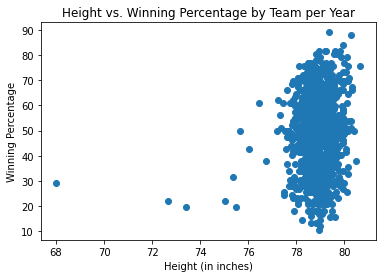

Training Set


Team Record  WinningPercentage  ...  avg_weight  years_exp   avg_salary
466   Warriors  38-44              0.463  ...     216.688     2.9375  4.81818e+06
1194     Kings  17-65              0.207  ...     218.714    4.28571     2.74e+06
1323      Jazz  36-30              0.545  ...     214.467        4.6      5.4e+06
1321      Jazz  25-57              0.305  ...     211.941          4      3.2e+06
1348      Jazz  44-38              0.537  ...     208.583       3.75  4.59167e+06
...        ...    ...                ...  ...         ...        ...          ...
1212     Kings  25-57              0.305  ...     208.778    3.16667  2.72727e+06
161       Nets  30-52              0.366  ...     217.867    4.86667     5.59e+06
479   Warriors  37-45              0.451  ...     214.722    3.38889      4.9e+06
1112      Suns  59-23              0.720  ...     211.133    5.66667  6.96154e+06
388    Pistons  25-41              0.379  ...     217.143    4.42857    3.675e+06

[674 rows x 9 columns]

Testing Set


Team Record  WinningPercentage  ...  avg_weight  years_exp   avg_salary
1334       Jazz  53-29              0.646  ...     216.643    7.42857     7.05e+06
417     Pistons  37-45              0.451  ...     215.833    2.38889     7.43e+06
536     Rockets  45-37              0.549  ...     226.353    6.11765  6.87273e+06
8       Celtics  62-20              0.756  ...       221.5     5.5625  8.31429e+06
1394    Bullets  35-47              0.427  ...     211.143        2.5  5.36667e+06
...         ...    ...                ...  ...         ...        ...          ...
107       Hawks  31-51              0.378  ...     200.667    3.13333  5.94545e+06
327   Mavericks  36-46              0.439  ...     211.071    2.78571     5.17e+06
697      Lakers  54-28              0.659  ...         195    3.21429     9.34e+06
1041      76ers  31-51              0.378  ...     219.364    4.54545  4.34286e+06
340   Mavericks  28-54              0.341  ...     207.923    2.15385  3.58889e+06

[290 rows x 9 columns]

In [ ]:
#Eliminate 2016 from the dataframe (no data for that year)
df = df[(df.start_year != 2016)]

#Plot for average height by winning percentage
plt.scatter(x=df['avg_height'],y=(df['Winning Percentage'] * 100))
plt.title("Height vs. Winning Percentage by Team per Year")
plt.xlabel("Height (in inches)")
plt.ylabel("Winning Percentage")
plt.show()

#Plot for average weight by winning percentage
plt.scatter(x=df['avg_weight'],y=df['Winning Percentage'])
plt.title("Weight vs. Winning Percentage by Team per Year")
plt.xlabel("Weight (in pounds)")
plt.ylabel("Winning Percentage")
plt.show()

#Drop all rows that contain NaN values, and split the training and testing set
#randomly, where the training set is 70% of the rows, and the testing set is
# 30% of the rows.
df = df.dropna()
df = df.rename(columns={'Winning Percentage' : 'WinningPercentage'})
train, test = train_test_split(df, test_size=0.3, train_size=0.7)

print("Training Set")
display(train)
print("Testing Set")
display(test)

As you can see in our graphs that the variable of weights in the NBA has no correlation to the winning percentages of NBA teams. However the variable height shows a stronger correlation with NBA team winning percentage than we had thought. 

In [ ]:
#Create our X and Y values for multilinear regression
X = np.asarray(train[['avg_height','avg_weight']], dtype=float)
Y = np.asarray(train['WinningPercentage'], dtype=float)
#Add constant value to get intercept
X = sm.add_constant(X)

#Run the data through our regression algorithm, and print the values
reg = sm.OLS(Y, X).fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     8.637
Date:                Fri, 14 May 2021   Prob (F-statistic):           0.000198
Time:                        22:52:16   Log-Likelihood:                 297.69
No. Observations:                 674   AIC:                            -589.4
Df Residuals:                     671   BIC:                            -575.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.8283      0.586     -3.119      0.0

# Initial Observations with Hypothesis

After using the data sets to plot the graphs of the average height of every NBA team vs the average winning percentages of every NBA team as well as the average weight of every team vs the average winning percentage of every NBA team, we noticed that there was not a huge correlation between the variables of height and weight of NBA teams compared to the average winning percentages of NBA teams. We took account the fact that the r squared value in the regression results was 0.025 which meant that the correlation was almost non-existent among the variables. In general, the higher the r squared value the more correlated the two plotted variables actually are. Furthermore, we used the p value to take a deeper dive into both height and weight which helped us determine that weight has absolutely no correlation to winning percentages in the NBA but height has a very strong correlation to winning percentage. The p value for weight and height was 0.087 and 0.000 respectively. Generally speaking, the lower the p value the more responsible the variable was for the correlation.In addition, we looked at the regression of each graph which further proved our initial hypothesis to be wrong. The graph comparing the average weight and average winning percentages of NBA teams had a very scattered data chart which showed the lack of correlation between the two variables. The other graph plotted with the average height and average winning percentages of NBA teams had a very steep regression which displayed that the height of an NBA player is strongly correlated to the winning percentage of NBA teams. This made us determine that our initial hypothesis was invalid and inaccurate. 

As a result, we determined that our initial hypothesis was actually a null hypothesis which showed that height actually has a large correlation to winning percentage and weight has no correlation to winning percentage. Therefore, we decided to create an alternative hypothesis where we would use the average salary and years of experience of NBA teams as variables to determine their correlation to NBA teams winning percentage. We felt that these variables should be more accurate due to noticeable trends in the NBA such as many NBA veterans leaving a team with less experience in order to join a more experienced championship “contending” team in hopes of winning an NBA championship. In addition, the NBA has strict rules where the salary of an NBA player must be at a certain minimum which is correlated to the number of years played in the NBA. 


In [ ]:
#Create the testing X values, and have the regression algorithm
#predict the winning percentage values
Xb = test[['avg_height','avg_weight']]
Xb = sm.add_constant(Xb)
predictions = reg.predict(Xb)
display(predictions)

1334    0.489797
417     0.515372
536     0.467133
8       0.474236
1394    0.503686
          ...   
107     0.496177
327     0.503804
697     0.505976
1041    0.508026
340      0.50357
Length: 290, dtype: object

In [ ]:
accuracy_array = []
increment_array = []
increment = 0.5
#Beginning at a 0.5 threshold, iterate down by 0.01, and calculate how many
#predictions are within that threshold, and divide the total number of correct
#predictions based on the threshold to an array
while increment > 0:
  temp = 0
  count = 0.0
  for index, row in test.iterrows():
    if abs(test['WinningPercentage'][index] - predictions[index]) < increment:
      count = count + 1.0
  temp = count / len(test)
  accuracy_array.append(temp * 100)
  increment_array.append(increment * 100)
  increment = increment - 0.01


This plot illustrates the accuracy of our model in predicting win rate, based upon both height and weight, compared to the percent threshold necessary to consider the prediction a success. The threshold value represents a range of numbers both above and below the actual value. The larger this threshold value is, the wider the range is for the prediction to be recognized as a success, resulting in a higher accuracy yield in the model. Ideally the model will show a high rate of accuracy for as low a threshold as possible. <br><br>
Our plot shows a poor level of accuracy in predicting win rate based upon the variables we chose. This could be expected after our previous analysis of the regression results. The R-squared value is very low meaning there is little correlation between average height and weight to team win rate. According to the plot, at a 10% threshold, which is really a 20% range, our model predicts with about 38% accuracy. Bump that up to a 20% threshold and our model is still only predicting about 75% of the win rates correctly. This only further emphasizes the lack of correlation between our initial variables of team height and weight to win rate.

In [ ]:
#Plot for accuracy by threshold
plt.plot(increment_array, accuracy_array, linewidth=5)
plt.title("Threshold vs. Percent Accuracy\n(Avg. Height and Weight vs. Winning Percentage)")
plt.xlabel("Percent Threshold for Success")
plt.ylabel("Percent Accuracy")
plt.show()

Our initial hypothesis was that the shift in NBA lineups, to what some call "small ball", can be supported by previous data to be a beneficial change. However, this was disproven as the two variables of height and weight showed very low correlation to team win rates. <br><br>
We still wanted to further explore the data set to see if we can find some variables that do strongly relate to a higher win rate. It would be interested to analyze what teams are doing or could be doing to lead to a more successful season. We decided that both years of experience and salary could be good indicators a higher team win rate. <br><br>
Below is a similar process to what was done above. First the data points for both average years of experience and salary are graphed with the corresponding win rate to get a visual on if there could be any relationship between them. According to the years of experience plot, it appears there could be an upward trend here. Over on the average salary plot, there is clearly an increasing trend for a higher win rate in teams with higher average salaries.

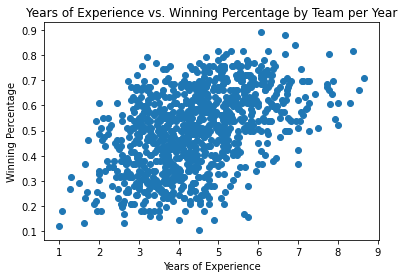

In [ ]:
#Redo the same process, but instead of using height and weight, use
#Years of Experience and Average Salary
df = df[(df.start_year != 2016)]

#Plot for average Years of Experience vs. Winning Percentage
plt.scatter(x=df['years_exp'],y=df['WinningPercentage'])
plt.title("Years of Experience vs. Winning Percentage by Team per Year")
plt.xlabel("Years of Experience")
plt.ylabel("Winning Percentage")
plt.show()

#Plot for average Salary vs. Winning Percentage
plt.scatter(x=df['avg_salary'],y=df['WinningPercentage'])
plt.title("Average Salary vs. Winning Percentage by Team per Year")
plt.xlabel("Average Salary (in USD)")
plt.ylabel("Winning Percentage")
plt.show()

Next we take these two variables and fit them to a linear regression algorithm to see how strongly they relate to a team's overall success. A summary of the regression results is printed for further analysis. <br><br>
The R-squared value of 0.762 implies a much higher correlation here as opposed to the variables we chose before, of which we got an R-squared value of 0.025. The low P value for both variables also indicate that our predictors, years of experience and salary, meaningfully relate to the win rates for each team. Now we can be certain that we have found characteristics of a team that correspond to the success of that season.

In [ ]:
#Create X and Y variables in the same process as previous, for running the
#linear regression algorithm
X2 = np.asarray(train[['avg_salary','years_exp']], dtype=float)
Y2 = np.asarray(train['WinningPercentage'], dtype=float)
X2 = sm.add_constant(X2)

#Fit the values to the linear regression algorithm, and print the results
reg2 = sm.OLS(Y2, X2).fit()
print(reg2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.762
Model:                            OLS   Adj. R-squared:                  0.761
Method:                 Least Squares   F-statistic:                     1074.
Date:                Fri, 14 May 2021   Prob (F-statistic):          6.89e-210
Time:                        22:52:23   Log-Likelihood:                 772.89
No. Observations:                 674   AIC:                            -1540.
Df Residuals:                     671   BIC:                            -1526.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0429      0.012      3.617      0.0

After confirming that these both average years of experience and average salary relate to a team's win rate, we can use these the model to make predictions on the winning percentage. These values will be used to analyze how accurate our model truly is.

In [ ]:
#Guess the values based on the testing dataset
Xb2 = test[['avg_salary','years_exp']]
Xb2 = sm.add_constant(Xb2)
predictions2 = reg2.predict(Xb2)

display(predictions2)

1334    0.662807
417     0.561439
536     0.619368
8       0.694738
1394    0.436627
          ...   
107     0.488102
327     0.431547
697     0.699973
1041    0.424008
340     0.318141
Length: 290, dtype: object

Below is the process in which we can find the model's accuracy based upon the different thresholds for allowing a success. The code loops through threshold values of 0 to 50 and determines whether the predictions are within this value range. We can then calculate the overall correctness within that threshold and record it in an array so that it can be utilized for further analysis.

In [ ]:
#Calculate accuracy by threshold increment in the same manner as previous
accuracy_array2 = []
increment_array2 = []
increment = 0.5
while increment > 0:
  temp = 0
  count = 0.0
  for index, row in test.iterrows():
    if abs(test['WinningPercentage'][index] - predictions2[index]) < increment:
      count = count + 1.0
  temp = count / len(test)
  accuracy_array2.append(temp * 100)
  increment_array2.append(increment * 100)
  increment = increment - 0.01


Similar to before, we now plot the correctness of our model given the differing threshold to gain insight on how accurate our model is. <br><br>
Here we can see our results are much improved from our previous model. With a 10% threshold we are getting 80% accuracy in predicting a teams' win rate based upon their average years of experience and average salary. This accuracy improves to above a 90% accuracy with a 13% threshold showing that our model is quite accurate.

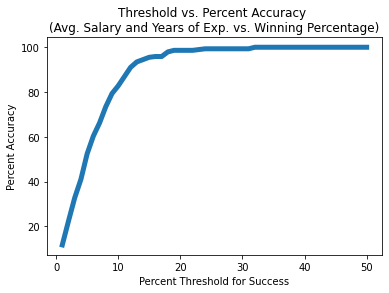

In [ ]:
#Plot for Accuracy vs. Threshold for Average Salary and Years of Experience vs.
#Winning Percentage
plt.plot(increment_array2, accuracy_array2, linewidth=5)
plt.title("Threshold vs. Percent Accuracy \n(Avg. Salary and Years of Exp. vs. Winning Percentage)")
plt.xlabel("Percent Threshold for Success")
plt.ylabel("Percent Accuracy")
plt.show()

#Conclusion

Initially, our group set out to analyze NBA rosters throughout the years to determine if there is any relationship between a team's average height/weight and their win rate. We have noticed many teams adopting what people are referring to as a small ball lineup, where the players are mostly perimeter players with ball handling and shooting skills. This was seen most notably in in the Golden State Warriors in recent years. We wanted to see if there was any historical NBA data that would support this shift in lineup structure. Upon further analysis our hypothesis was disproven as there was little correlation between a team's average height/weight and their win rate that season. This resulted in a model that could not accurately predict a team's win percentage based on these variables. So we decided to look further for predictors that would more meaningfully relate to a team's success. We landed on a team's average years of experience and average salary. After collecting the data and running the linear regression algorithm on these predictors, we found different results. These variables appear to be strongly correlated to win percentage. Our model was able to closely predict the win rate of a team based on these values. While our initial hypothesis did not pan out, we are happy we were able to find characteristics of a team that associate with an NBA team's success.

#Interesting Information
Below are some outliers that can be found from the NBA dataset. It provides an interesting look into the success of teams with the highest or lowest values of various characteristics.

In [ ]:
#Interesting Information
df['avg_height'] = pd.to_numeric(df['avg_height'])
df['avg_weight'] = pd.to_numeric(df['avg_weight'])
df['years_exp'] = pd.to_numeric(df['years_exp'])
df['avg_salary'] = pd.to_numeric(df['avg_salary'])

#Getting Max and Min values for each interesting variable
max_winp = df['WinningPercentage'].idxmax()
min_winp = df['WinningPercentage'].idxmin()
max_height = df['avg_height'].idxmax()
min_height = df['avg_height'].idxmin()
max_weight = df['avg_weight'].idxmax()
min_weight = df['avg_weight'].idxmin()
max_yearsexp = df['years_exp'].idxmax()
min_yearsexp = df['years_exp'].idxmin()
max_avgsalary = df['avg_salary'].idxmax()
min_avgsalary = df['avg_salary'].idxmin()

#Displaying Information
print("Tallest Team")
display(df.loc[[max_height]])
print("Shortest Team")
display(df.loc[[min_height]])
print("Best Team")
display(df.loc[[max_winp]])
print("Worst Team")
display(df.loc[[min_winp]])
print("Heaviest Team")
display(df.loc[[max_weight]])
print("Lightest Team")
display(df.loc[[min_weight]])
print("Most Experience")
display(df.loc[[max_yearsexp]])
print("Least Experience")
display(df.loc[[min_yearsexp]])
print("Highest Average Salary")
display(df.loc[[max_avgsalary]])
print("Lowest Average Salary")
display(df.loc[[min_avgsalary]])

Tallest Team


Team Record  WinningPercentage  ...  avg_weight  years_exp  avg_salary
692  Lakers  62-20              0.756  ...       214.0   4.866667   8375000.0

[1 rows x 9 columns]

Shortest Team


Team Record  WinningPercentage  ...  avg_weight  years_exp  avg_salary
325  Mavericks  24-58              0.293  ...   188.37037   3.666667   2743750.0

[1 rows x 9 columns]

Best Team


Team Record  WinningPercentage  ...  avg_weight  years_exp    avg_salary
453  Warriors   73-9               0.89  ...  217.714286   6.071429  6.157143e+06

[1 rows x 9 columns]

Worst Team


Team Record  WinningPercentage  ...  avg_weight  years_exp     avg_salary
185  Bobcats   7-59              0.106  ...     221.375        4.5  816666.666667

[1 rows x 9 columns]

Heaviest Team


Team Record  WinningPercentage  ...  avg_weight  years_exp    avg_salary
259  Cavaliers  57-25              0.695  ...  233.307692   7.230769  4.081818e+06

[1 rows x 9 columns]

Lightest Team


Team Record  WinningPercentage  ...  avg_weight  years_exp  avg_salary
325  Mavericks  24-58              0.293  ...   188.37037   3.666667   2743750.0

[1 rows x 9 columns]

Most Experience


Team Record  WinningPercentage  ...  avg_weight  years_exp    avg_salary
758  Heat  58-24              0.707  ...  229.117647   8.647059  7.006667e+06

[1 rows x 9 columns]

Least Experience


Team Record  WinningPercentage  ...  avg_weight  years_exp     avg_salary
1023  76ers  10-72              0.122  ...  216.166667        1.0  733333.333333

[1 rows x 9 columns]

Highest Average Salary


Team Record  WinningPercentage  ...  avg_weight  years_exp  avg_salary
26  Celtics  56-26              0.683  ...  207.666667        4.2  12375000.0

[1 rows x 9 columns]

Lowest Average Salary


Team Record  WinningPercentage  ...  avg_weight  years_exp     avg_salary
662  Lakers  17-65              0.207  ...  225.466667   5.133333  733333.333333

[1 rows x 9 columns]